# Automatic differentiation

1. Implement a PyTorch loop as described in the slides <https://jjv.ie/slides/autodiff.pdf>
2. Implement your own Linear layer. Check first that it learns on simple linear regression by implementing a SquaredLoss
3. Implement ReLU, CrossEntropyLoss, Sequential (that composes layers) modules

## 1. Implement a PyTorch loop for a MLP with classification

We will use the Moons dataset that is non linear.

In [ ]:
!uv init
!uv add scikit-learn matplotlib numpy pandas torch

In [2]:
from sklearn.datasets import make_moons

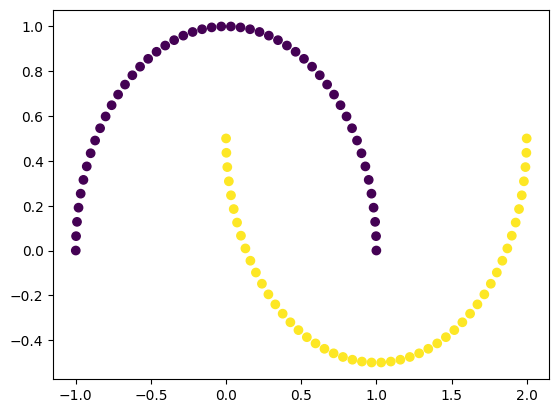

In [3]:
import matplotlib.pyplot as plt
import numpy as np

X, y = make_moons()
plt.scatter(X[:, 0], X[:, 1], c=y)

In [4]:
X.shape

(100, 2)

Which loss should you consider for classification? Here are a couple reads:

- [NLLLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)
- [CrossEntropyLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- [BCELoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)
- [BCEWithLogitsLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)

In [ ]:
from torch import nn
import torch

BATCH_SIZE = 10
X_train = torch.Tensor(X)
y_train = torch.Tensor(y)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = nn.Sequential(
    # Various configurations of Linear / ReLU layers
)

criterion = None  # Your loss for classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


n_epochs = 500
for epoch in range(n_epochs):
    losses = []
    accuracies = []
    for batch_inputs, batch_labels in trainloader:
        outputs = model(batch_inputs)  # According to your choices you may need to use flatten()

        loss = criterion(outputs, batch_labels)  # The loss function you picked is used here
        losses.append(loss.item())

        acc = 0  # Compute accuracy here
        accuracies.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print('Epoch', epoch, '- loss', np.mean(losses), 'acc', np.mean(accuracies))

## 2. Implement your own Linear layer

Every Module we implement will have a couple methods:

- `__init__` attributes (parameters, gradient)
- `forward` to compute its output
- `backward` to backpropagate its gradient
- `step` to make one step of gradient descent

In [ ]:
class Module:
    def __call__(self, *x):  # Just an alias from model(param1, param2) to model.forward(param1, param2)
        return self.forward(*x)  # We may need several parameters for the loss modules

In [ ]:
GAMMA = 0.01  # Learning rate

class Linear(Module):
    def __init__(self, dim1, dim2):
        self.W = np.random.random(...)  # What is its shape?
        self.grad_W = None

    def forward(self, x):
        # One linear layer
        raise NotImplementedError

    def backward(self, grad):
        # Compute, store and return gradient of loss with respect to W: grad_W is dL/dW
        raise NotImplementedError

    def step(self):
        # One step of gradient descent
        raise NotImplementedError

We will consider simple linear regression data

In [6]:
import pandas as pd

df = pd.read_csv('../1housing.csv')
df

,size,price
0,46.0,767.0
1,49.0,818.0
2,39.0,683.0
3,14.0,282.0
4,34.0,656.0
5,32.0,530.0
6,28.0,539.0
7,52.0,916.0
8,65.0,1063.0
9,51.0,848.0


In [ ]:
class SquaredLoss(Module):
    def __init__(self):
        pass

    def forward(self, outputs, y):
        # Store those for computing the gradient later
        self.outputs = outputs
        self.y = y
        # Compute the loss
        raise NotImplementedError

    def backward(self):
        # Return the gradient dL/df where f is the model and f(x) the outputs
        raise NotImplementedError

If in trouble, troubleshoot your gradients or reduce learning rate.

In [ ]:
X = np.array(df[['size']])
y = np.array(df['price'])
print(X, y)

N = len(X)

model = Linear(...)

squared_loss = SquaredLoss()
for epoch in range(100):
    accuracies = []
    losses = []
    for i in range(N):
        outputs = model(X[i])

        loss = squared_loss(outputs, y[i])
        losses.append(loss)
    
        loss_grad = squared_loss.backward()
        model.backward(loss_grad)
        model.step()
    if epoch % 10 == 0:
        print('epoch', epoch, '- loss', np.mean(losses), 'param', model.W)

# 3. Implement everything else we need for training MLPs for classification

Implement a ReLU layer. You may use `np.maximum`:

In [ ]:
x = np.random.random((3, 2)) - 0.5
np.maximum(0, x)

In [ ]:
class ReLU(Module):
    def __init__(self):
        pass

    def forward(self, x):
        # Store input for computing gradient later, and return output
        self.x = x
        raise NotImplementedError

    def backward(self, grad):
        # Compute gradient and return it
        raise NotImplementedError

    def step(self):
        pass

For the cross entropy loss, we will need the softmax function, you may use `np.exp`.

For a vector $z$ of logits, $\textrm{softmax}(z)_i \propto \exp z_i$

In [ ]:
def softmax(logits):
    # Compute softmax of given logits
    raise NotImplementedError
    
assert softmax([1, 2, 3]).sum() == 1.

We will also need to compute the one-hot vector of a given target class. For this you may just use `np.zeros_like(outputs)` that gives you a vector of 0s having the same size as `outputs`; and set the right bit.

The gradient of cross entropy loss with respect to the logits has a simple form, see [the slides from Grisel and Ollion](https://m2dsupsdlclass.github.io/lectures-labs/slides/02_backprop/index.html#42).

In [ ]:
class CrossEntropyLoss(Module):
    def __init__(self):
        pass

    def forward(self, y, outputs):
        # Store arguments then compute the cross-entropy loss that is the ith component of -log probas where i is the right class
        self.outputs = outputs
        self.y = y
        raise NotImplementedError
    
    def backward(self):
        # Compute the gradient of the cross-entropy loss with respect to the inputs i.e. logits
        raise NotImplementedError

In [7]:
[3, 2, 4, 1][::-1]  # You may need this

[1, 4, 2, 3]

In [ ]:
class Sequential(Module):
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        # Make the computation layer by layer
        raise NotImplementedError

    def backward(self, grad):
        # ->Back<-propagate layer by layer
        raise NotImplementedError

    def step(self):
        # All gradients have been computed; now just do gradient descent on each trainable parameter
        raise NotImplementedError

In [ ]:
N = len(X)

model = Sequential([
    # Try various configurations of MLP architectures
])

cross_entropy = CrossEntropyLoss()
for epoch in range(500):
    accuracies = []
    losses = []
    for i in range(N):
        outputs = model(X[i])

        loss = cross_entropy(y[i], outputs)
        losses.append(loss)

        acc = outputs.argmax() == y[i]
        accuracies.append(acc)
    
        loss_grad = cross_entropy.backward()
        model.backward(loss_grad)
        model.step()
    if epoch % 50 == 0:
        print('Epoch', epoch, '- acc', np.mean(accuracies), 'loss', np.mean(losses))